# Load Existing Signals
There are cases where you have trained models and already computed the signals. In this tutorial, we will show how Privacy meter can load the existing signals to perform the attacks

In [108]:
from privacy_meter.audit_report import ROCCurveReport
from privacy_meter.constants import InferenceGame
from privacy_meter.information_source import InformationSource
from privacy_meter.audit import Audit, MetricEnum
import numpy as np

## Loading the signals for population attacks

For the population attack, the adversary needs to compute the signals on the members, non-members, and population data sampled from the same distribution. In this case, you need to provide three `npz` files with the name `PopulationMetric_target_member.npz`, `PopulationMetric_target_non_member.npz` and `PopulationMetric_reference.npz`. In this example, we provide the pre-computed signals in the `existing_signals/population` folder. The size should be `(number of models, number of samples)`, which is `(1, number of samples)` in this case.

In [109]:
# First, construct the dummy information source.
target_info_source = InformationSource(
    models=[],
    datasets=[]
)

reference_info_source = InformationSource(
    models=[],
    datasets=[] 
)

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    logs_directory_names="existing_signals/population/" # Indicate the folder where the signals are saved.
)
audit_obj.prepare() #Load the signals from the disk
audit_results = audit_obj.run()[0] # Run the attack


Results are stored in: ['existing_signals/population/']


In [110]:
# Plot the results
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

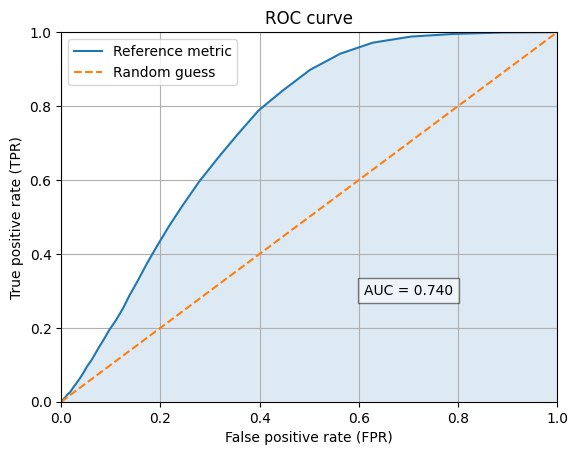

AUC = 0.740


<Figure size 640x480 with 0 Axes>

In [111]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

## Loading the signals for reference attacks
For the reference attacks, the adversary needs to compute the signals for the members and non-members from the target model and compare them with the signals computed for the members and non-members from the reference models. Therefore, we need to have four signal files named `ReferenceMetric_target_member.npz`, `ReferenceMetric_target_non_member.npz`, `ReferenceMetric_reference_member.npz`, and `ReferenceMetric_reference_non_member.npz`. In this example, we provide the pre-computed signals in the `existing_signals/reference` folder. The shape of the array should be `(number of models, number of samples).` 


In [112]:
# First, construct the dummy information source.
target_info_source = InformationSource(
    models=[],
    datasets=[]
)

reference_info_source = InformationSource(
    models=[],
    datasets=[] 
)

audit_obj = Audit(
    metrics=MetricEnum.REFERENCE,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    logs_directory_names="existing_signals/reference/" # Indicate the folder where the signals are saved.
)
audit_obj.prepare() #Load the signals from the disk
audit_results = audit_obj.run()[0] # Run the attack


Results are stored in: ['existing_signals/reference/']


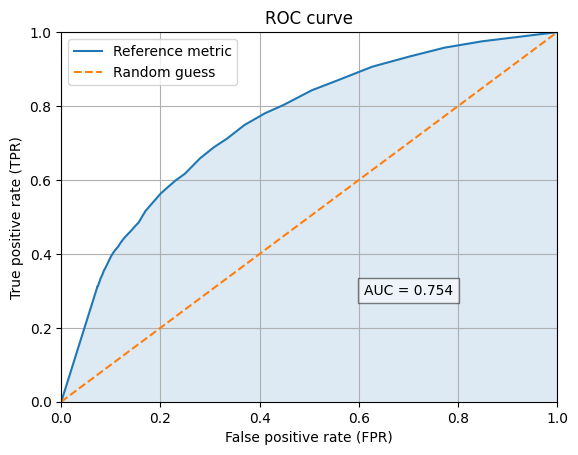

AUC = 0.754


<Figure size 640x480 with 0 Axes>

In [113]:
# Plot the results
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

# Load the signals for online attacks

In the online attacks, the adversary trains a set of models with the target point (In Models) and without the target point (Out Models) and then compute the signals based on the target model. There should be four files: `ReferenceMetric_target_member.npz`, `ReferenceMetric_target_non_member.npz`, `ReferenceMetric_reference_non_member_in.npz`, `ReferenceMetric_reference_non_member_out.npz`, `ReferenceMetric_reference_member_in.npz`, and `ReferenceMetric_reference_member_out.npz`. In this example, we provide the pre-computed signals in the `existing_signals/reference_online` folder.

In `ReferenceMetric_reference_non_member_in,` the shape of the array should be `(number of samples, number of models, number of arguments).` If the adversary queries the model only based on the original data point, the `number of arguments` will be 1. On the other hand, if the adversary argues the target point and queries the model based on a set of arguments point, the `number of arguments` will reflect how many arguments the adversary computes on the target data.

In [130]:
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
import copy
# This implementation is based on the lira attack implememtation: https://github.com/tensorflow/privacy/tree/master/research/mi_lira_2021

in_member_signals = np.load('existing_signals/reference_online/ReferenceMetric_reference_member_in.npz', allow_pickle=True)['arr_0']
out_member_signals = np.load('existing_signals/reference_online/ReferenceMetric_reference_member_out.npz', allow_pickle=True)['arr_0']
in_non_member_signals = np.load('existing_signals/reference_online/ReferenceMetric_reference_non_member_in.npz', allow_pickle=True)['arr_0']
out_non_member_signals = np.load('existing_signals/reference_online/ReferenceMetric_reference_non_member_out.npz', allow_pickle=True)['arr_0']

target_member_signals = np.load('existing_signals/reference_online/ReferenceMetric_target_member.npz', allow_pickle=True)['arr_0']
target_non_member_signals = np.load('existing_signals/reference_online/ReferenceMetric_target_non_member.npz', allow_pickle=True)['arr_0']

in_signals = np.concatenate([in_member_signals, in_non_member_signals],axis=0)
out_signals = np.concatenate([out_member_signals, out_non_member_signals],axis=0)
target_signals = np.array([np.concatenate([target_member_signals, target_non_member_signals],axis=0)])
membership = np.array([np.concatenate([np.ones(len(target_member_signals)), np.zeros(len(target_non_member_signals))], axis=0)])

# Fit the distributions
mean_in = np.median(in_signals, 1)
mean_out = np.median(out_signals, 1)
fix_variance = True # indicate whether to fix the variance or not
if fix_variance:
    std_in = np.std(in_signals)
    std_out = np.std(in_signals)
else:
    std_in = np.std(in_signals, 1)
    std_out = np.std(out_signals, 1)


In [131]:
prediction = []
answers = []
for ans, sc in zip(membership, target_signals):
    pr_in = -norm.logpdf(sc, mean_in, std_in + 1e-30)
    pr_out = -norm.logpdf(sc, mean_out, std_out + 1e-30)
    score = pr_in - pr_out
    prediction.extend(score.mean(1))
    answers.extend(ans)

AUC 0.6843, Accuracy 0.6129, TPR@0.1%FPR of 0.0507


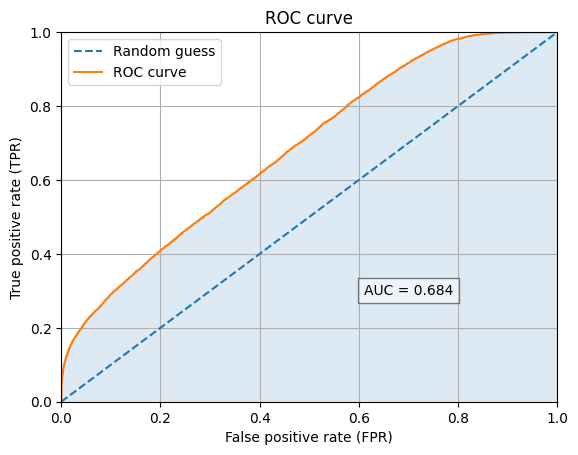

In [133]:
prediction = np.array(prediction)
answers = np.array(answers, dtype=bool)
fpr_list, tpr_list, _ = roc_curve(answers, -prediction)
acc = np.max(1 - (fpr_list + (1 - tpr_list)) / 2)
roc_auc = auc(fpr_list, tpr_list)

low = tpr_list[np.where(fpr_list < 0.001)[0][-1]]
print("AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f" % (roc_auc, acc, low))
range01 = np.linspace(0, 1)
plt.fill_between(fpr_list, tpr_list, alpha=0.15)
plt.plot(range01, range01, "--", label="Random guess")
plt.plot(fpr_list, tpr_list, label="ROC curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.legend()
plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.title("ROC curve")
plt.text(
    0.7,
    0.3,
    f"AUC = {roc_auc:.03f}",
    horizontalalignment="center",
    verticalalignment="center",
    bbox=dict(facecolor="white", alpha=0.5),
)
plt.show()
